In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import copy
import json
from pathlib import Path
from textwrap import wrap
  

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from bella.helper import read_config
from bella.parsers import semeval_14, dong, election
from bella import evaluation
from bella.evaluation import distinct_sentiment_metrics
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
##
#  ADD YOUR CONFIG FILE PATH HERE 
##
CONFIG_FP = Path('..', 'config.yaml')
# Load all of the datasets
youtubean_test = semeval_14(read_config('youtubean_test', CONFIG_FP))
semeval_14_rest_test = semeval_14(read_config('semeval_2014_rest_test', CONFIG_FP))
semeval_14_lap_test = semeval_14(read_config('semeval_2014_lap_test', CONFIG_FP))
dong_test = dong(read_config('dong_twit_test_data', CONFIG_FP))
_, election_test = election(read_config('election_folder_dir', CONFIG_FP))
mitchel_test = semeval_14(read_config('mitchel_test', CONFIG_FP))
dataset_test = {'SemEval 14 Laptop': semeval_14_lap_test,
                'SemEval 14 Restaurant': semeval_14_rest_test,
                'Dong Twitter': dong_test,
                'Election Twitter': election_test,
                'YouTuBean': youtubean_test,
                'Mitchel': mitchel_test}
# results folders
results_folder = Path(read_config('results_folder', CONFIG_FP))
lstms_folder = results_folder.joinpath('TDLstm')
target_dep_folder = results_folder.joinpath('Target Dependent')
tdparse_folder = results_folder.joinpath('TDParse')
# Result files
lstm_name_fp = ('LSTM', Path(lstms_folder, 'LSTM', 'dataset predictions.json'))
tdlstm_name_fp = ('TDLSTM', Path(lstms_folder, 'TDLSTM', 'dataset predictions.json'))
tclstm_name_fp = ('TCLSTM', Path(lstms_folder, 'TCLSTM', 'dataset predictions.json'))
targ_dep_name_fp = ('Target-Dep', 
                    Path(target_dep_folder, 'Target Dependent', 'dataset predictions.json'))
targ_plus_name_fp = ('Target-Dep+', Path(target_dep_folder, 'Target Dependent Plus', 'dataset predictions.json'))
tdparse_name_fp = ('TDParse', Path(tdparse_folder, 'TDParse', 'dataset predictions.json'))
tdparse_plus_name_fp = ('TDParse+', Path(tdparse_folder, 'TDParsePlus', 'dataset predictions.json'))
all_results = [lstm_name_fp, tdlstm_name_fp, tclstm_name_fp, targ_dep_name_fp, targ_plus_name_fp,
               tdparse_name_fp, tdparse_plus_name_fp]
all_results = {name: json.load(results_fp.open('r')) for name, results_fp in all_results}

# Mass Evaluation Result analysis

## Macro F1 3-Way

In [3]:
f1_results = evaluation.evaluate_models(f1_score, dataset_test, all_results, 
                                        dataframe=True, average='macro')
(f1_results * 100).round(2)

,LSTM,TDLSTM,TCLSTM,Target-Dep,Target-Dep+,TDParse,TDParse+
Dong Twitter,63.60,66.09,67.14,65.66,65.67,65.74,68.06
Election Twitter,38.70,43.60,42.08,45.47,45.93,46.32,44.93
Mitchel,47.17,51.16,41.03,40.76,42.86,40.96,50.03
SemEval 14 Laptop,47.84,57.91,46.80,59.97,63.73,59.98,63.85
SemEval 14 Restaurant,46.36,57.68,55.38,56.16,57.71,59.49,61.11
YouTuBean,45.93,45.47,38.07,53.14,55.56,71.67,67.68
Mean,48.27,53.65,48.42,53.53,55.24,57.36,59.28


Text(0.5,1,'Macro F1')

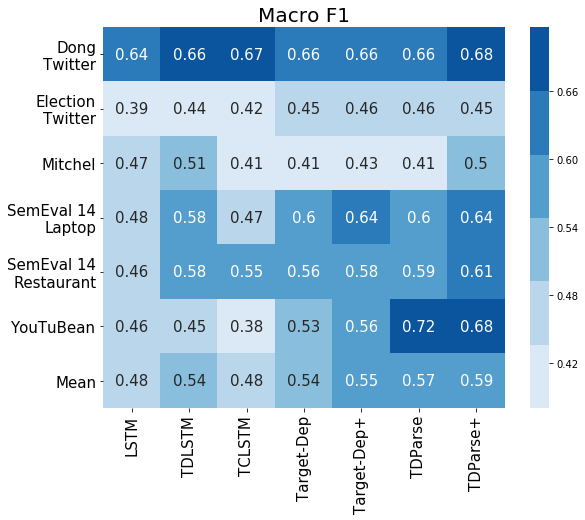

In [4]:
vis_f1 = copy.deepcopy(f1_results)
vis_f1.columns = [col.replace(' 3 Class Macro F1', '') for col in vis_f1.columns]
vis_f1.index = ['\n'.join(wrap(index, 10)) for index in vis_f1.index]
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(vis_f1, annot=True, annot_kws={'size':15},
            cmap=sns.color_palette("Blues"), ax=ax)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Macro F1', fontdict={'fontsize':20})

## Accuracy

In [5]:
acc_results = evaluation.evaluate_models(accuracy_score, dataset_test, 
                                         all_results, dataframe=True)
(acc_results * 100).round(2)

,LSTM,TDLSTM,TCLSTM,Target-Dep,Target-Dep+,TDParse,TDParse+
Dong Twitter,66.47,68.79,69.51,67.34,67.77,68.35,70.09
Election Twitter,53.80,57.30,57.22,57.65,56.63,57.22,56.40
Mitchel,72.14,73.45,69.81,72.64,72.85,73.25,74.47
SemEval 14 Laptop,58.93,65.52,57.05,67.87,70.85,68.50,70.69
SemEval 14 Restaurant,71.07,74.38,72.41,73.84,74.64,73.39,76.16
YouTuBean,72.50,72.50,66.67,70.83,72.50,81.25,80.42
Mean,65.82,68.66,65.44,68.36,69.21,70.33,71.37


## Macro F1 2-way

We can then look at the 2 way Macro F1 score which evaluates how well the models can predict Positive or Negative sentiment while still taking into account prediciting the neutral class.

In [6]:
(evaluation.evaluate_models(f1_score, dataset_test, all_results, 
                           dataframe=True, average='macro', labels=[-1, 1]) * 100).round(2)

,LSTM,TDLSTM,TCLSTM,Target-Dep,Target-Dep+,TDParse,TDParse+
Dong Twitter,59.19,61.59,62.94,62.39,61.92,61.33,64.44
Election Twitter,34.02,36.85,34.39,39.97,41.02,41.27,39.49
Mitchel,29.03,34.49,20.42,19.22,22.53,19.47,32.73
SemEval 14 Laptop,64.46,65.29,57.36,68.62,71.82,69.79,71.97
SemEval 14 Restaurant,69.54,71.08,68.35,73.61,73.78,70.90,76.14
YouTuBean,27.05,26.27,17.71,38.99,42.34,64.02,58.22
Mean,47.22,49.26,43.53,50.47,52.23,54.46,57.17


## Macro F1, 1 Distinct Sentiment subset

Now we look at the results of trying to predict the sentiment of all targets that are only in sentence that contain one distinct sentiment. This should be a result that is good for the LSTM model as it does not take into account any target information. However as we can see below the LSTM is one of the worse models.

In [7]:
(evaluation.evaluate_models(distinct_sentiment_metrics, dataset_test, all_results, custom_metric=True,
                            dataframe=True, distinct_sentiments=1, 
                            metric_func=f1_score, average='macro') * 100).round(2)

,LSTM,TDLSTM,TCLSTM,Target-Dep,Target-Dep+,TDParse,TDParse+
Dong Twitter,63.60,66.09,67.14,65.66,65.67,65.74,68.06
Election Twitter,45.09,47.29,42.55,50.25,50.33,48.83,48.45
Mitchel,47.64,52.41,41.13,41.52,43.13,41.82,51.27
SemEval 14 Laptop,49.06,58.30,47.61,61.03,67.18,60.75,66.15
SemEval 14 Restaurant,48.19,59.89,54.73,57.17,60.52,57.77,62.93
YouTuBean,46.68,46.22,38.66,54.22,57.02,73.42,69.23
Mean,50.04,55.03,48.64,54.98,57.31,58.05,61.02


## Macro F1, 2 Distinct Sentiment subset

We do the same as above but for 2 distinct sentiments per sentence. We remove the Dong twitter dataset from this experiment due to it only containing Tweets with one distinct sentiment.

In [8]:
two_dist_sent = evaluation.evaluate_models(distinct_sentiment_metrics, dataset_test, 
                                           all_results, custom_metric=True,
                                           dataframe=True, distinct_sentiments=2, 
                                           metric_func=f1_score, average='macro')
two_dist_sent = two_dist_sent.drop('Dong Twitter')
two_dist_sent = two_dist_sent.drop('Mean')
two_dist_mean = pd.Series(two_dist_sent.mean(), name='Mean')
(two_dist_sent.append(two_dist_mean) * 100).round(2)

/home/andrew/Envs/Bella/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,LSTM,TDLSTM,TCLSTM,Target-Dep,Target-Dep+,TDParse,TDParse+
Election Twitter,34.12,39.89,41.29,41.91,43.03,44.00,42.18
Mitchel,38.00,36.24,39.21,31.60,34.83,30.65,37.92
SemEval 14 Laptop,33.67,52.94,40.18,51.86,47.37,51.86,50.80
SemEval 14 Restaurant,37.97,48.60,51.46,48.45,48.63,58.01,53.61
YouTuBean,20.51,20.51,20.51,31.52,31.11,42.22,42.22
Mean,32.86,39.64,38.53,41.07,40.99,45.35,45.34


## Macro F1, 3 Distinct Sentiment subset

Lastly the same as above but for 3 distinct sentiments. As the majority of the datasets have very few 3 distinct sentiments per sentence we only look at the Twitter Elections datases (8.78% of the dataset contains 3 distinct sentiments).

In [9]:
three_dist_sent = evaluation.evaluate_models(distinct_sentiment_metrics, dataset_test, 
                                             all_results, custom_metric=True,
                                             dataframe=True, distinct_sentiments=3, 
                                             metric_func=f1_score, average='macro')
(three_dist_sent.loc['Election Twitter'].sort_values(ascending=False) * 100).round(2)

/home/andrew/Envs/Bella/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TDParse        44.89
TDParse+       42.90
TDLSTM         42.75
TCLSTM         42.36
Target-Dep     41.88
Target-Dep+    40.88
LSTM           29.55
Name: Election Twitter, dtype: float64